# Fashion Detection: Image Classification with CNN

#### authors: [@MelissaPerez09](https://github.com/MelissaPerez09), [@bl33h](https://github.com/bl33h), [@Mendezg1](https://github.com/Mendezg1)

In [43]:
import os
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np

In [44]:
images_dir = "./data/JPEGImages/"
annotations_dir = "./data/Annotations/"
labels = "./data/labels.txt"

In [45]:
image_files = os.listdir(images_dir)
image_ids = [os.path.splitext(file)[0] for file in image_files if file.lower().endswith(('.jpg', '.jpeg', '.png'))]

In [46]:
# read labels
with open(labels, 'r') as f:
    labels = [label.strip().replace(',', '') for label in f.read().splitlines()]

# map labels to integers
label_map = {label: idx for idx, label in enumerate(labels)}

print(label_map)

{'sunglass': 0, 'hat': 1, 'jacket': 2, 'shirt': 3, 'pants': 4, 'shorts': 5, 'skirt': 6, 'dress': 7, 'bag': 8, 'shoe': 9}


In [47]:
# load image and bounding boxes
def load_image_and_boxes(image_id):
    # load image
    image_path = os.path.join(images_dir, f"{image_id}.jpg")
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # load bounding boxes (annotations xml)
    annotation_path = os.path.join(annotations_dir, f"{image_id}.xml")
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    
    boxes = []
    labels = []
    
    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        
        # bounding box coordinates
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label_map[label])
    
    return image, boxes, labels

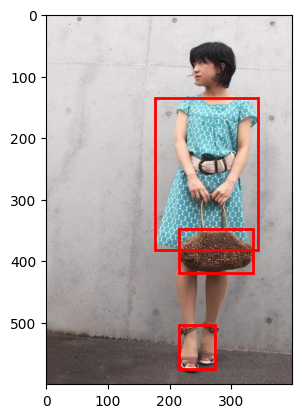

In [48]:
# visualize image and bounding boxes

image, boxes, labels = load_image_and_boxes(image_ids[0])

plt.imshow(image)
for box in boxes:
    xmin, ymin, xmax, ymax = box
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='red', linewidth=2))
plt.show()

In [49]:
def apply_clahe_rgb(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

In [50]:
cropped_images_array = []

def normalize_image(image):
    return image / 255.0

# Function to crop and normalize images, and save them in an array
def crop_normalize_and_save_images_to_array(image_id, cropped_images_array, target_size=(128, 128)):
    image, boxes, labels = load_image_and_boxes(image_id)
    
    for idx, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box
        cropped_image = image[ymin:ymax, xmin:xmax]
        resized_image = cv2.resize(cropped_image, target_size, interpolation=cv2.INTER_CUBIC)
        cropped_images_array.append((resized_image, labels[idx], image_id))

for image_id in image_ids[:2144]:
    crop_normalize_and_save_images_to_array(image_id, cropped_images_array)

In [51]:
def quality_improvement(image):
    clahe_image = apply_clahe_rgb(image)
    bilateral_filtered = cv2.bilateralFilter(clahe_image, d=9, sigmaColor=75, sigmaSpace=75)

    kernel = np.array([[0, -0.5, 0],
                   [-0.5, 3, -0.5],
                   [0, -0.5, 0]])
    sharpened = cv2.filter2D(bilateral_filtered, -1, kernel)
    

    return normalize_image(sharpened)

improved_images_array = []
# Apply quality improvement to cropped images
for idx, (image, label, id) in enumerate(cropped_images_array):
    improved_image = quality_improvement(image)
    improved_images_array.append((improved_image, label, id))

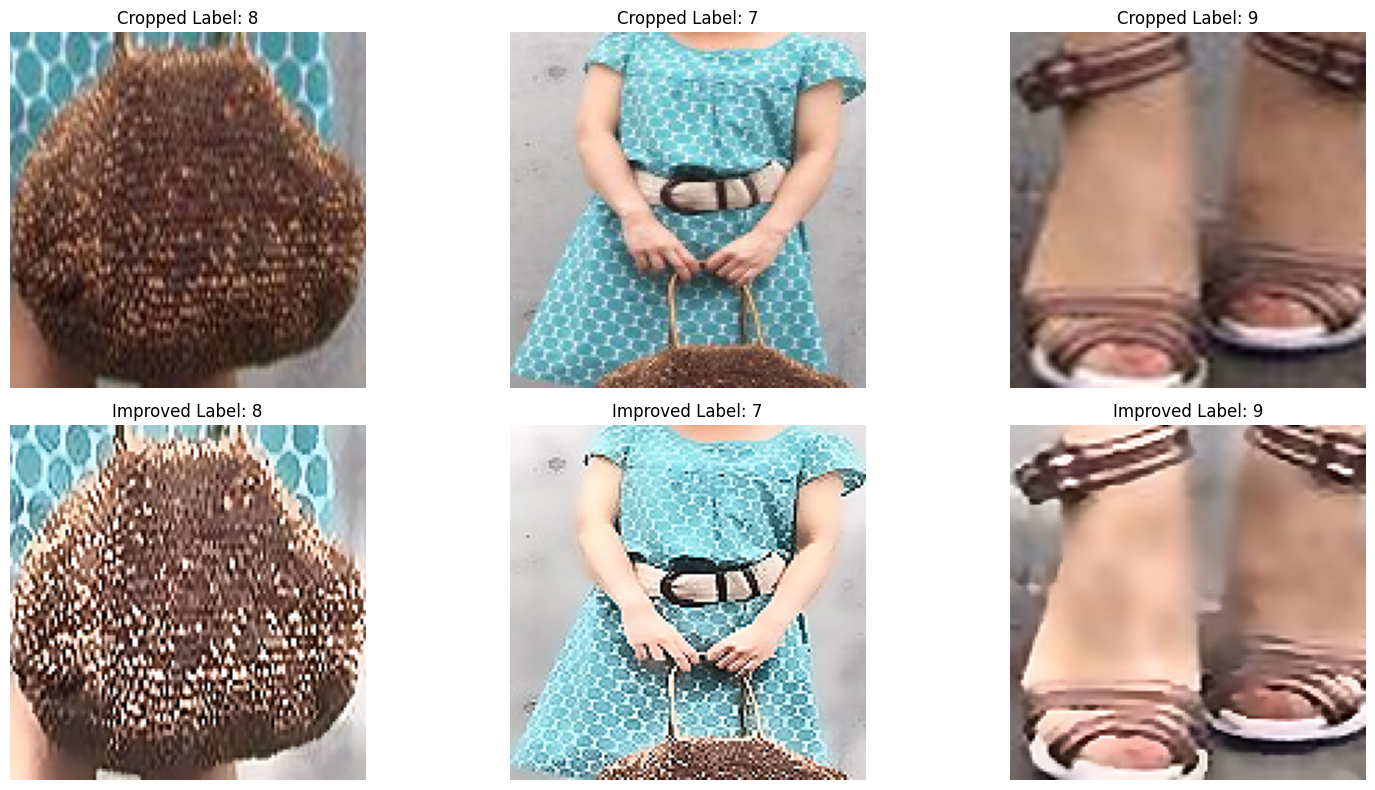

In [52]:
fig, axs = plt.subplots(2, 3, figsize=(16, 8))

for i in range(3):
    img, label, _ = cropped_images_array[i]
    axs[0, i].imshow(img)
    axs[0, i].set_title(f"Cropped Label: {label}")
    axs[0, i].axis('off')

for i in range(3):
    img, label, _ = improved_images_array[i]
    axs[1, i].imshow(img)
    axs[1, i].set_title(f"Improved Label: {label}")
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

In [53]:
from collections import defaultdict

new_images_array = []

improved_by_image = defaultdict(list)
for improved_image, label, image_id in improved_images_array:
    improved_by_image[image_id].append((improved_image, label))


for idx, (image_id, improved_list) in enumerate(improved_by_image.items()):
    image, boxes, labels_in_image = load_image_and_boxes(image_id)
    image_overlay = image.copy()
    # For each improved image, find its bounding box and overlay
    for (improved_image, label) in improved_list:
        # Find the index of the bounding box for this label
        try:
            box_idx = labels_in_image.index(label)
        except ValueError:
            continue  # skip if label not found
        xmin, ymin, xmax, ymax = boxes[box_idx]
        improved_img_uint8 = (improved_image * 255).astype(np.uint8)
        improved_resized = cv2.resize(improved_img_uint8, (xmax - xmin, ymax - ymin), interpolation=cv2.INTER_CUBIC)
        image_overlay[ymin:ymax, xmin:xmax] = improved_resized
    new_images_array.append((image_overlay, labels_in_image))
        

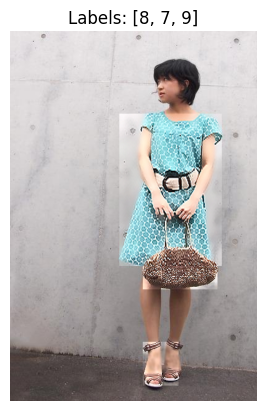

In [54]:
img, labels = new_images_array[0]
plt.imshow(img)
plt.title(f"Labels: {labels}")
plt.axis('off')
plt.show()

In [55]:
import os
import cv2

output_dir = "./data/Images"
os.makedirs(output_dir, exist_ok=True)

# It only needs to save the images once
if len(os.listdir(output_dir)) == 0:
    for idx, (img, labels) in enumerate(new_images_array):
        filename = os.path.join(output_dir, f"image_{idx}.png")
        cv2.imwrite(filename, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    print("Images saved.")
else:
    print("Images already exist. Skipping save.")


Images saved.


In [56]:
from ultralytics import YOLO
import yaml
import os
from sklearn.model_selection import train_test_split

# Prepare YOLO dataset directory structure
if not os.path.exists('./data/yolo_dataset'):
    yolo_dataset_dir = './data/yolo_dataset'
    images_output_dir = os.path.join(yolo_dataset_dir, 'images')
    labels_output_dir = os.path.join(yolo_dataset_dir, 'labels')
    os.makedirs(images_output_dir, exist_ok=True)
    os.makedirs(labels_output_dir, exist_ok=True)

    # Save images and labels in YOLO format
    indices = np.arange(len(new_images_array))
    train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42, shuffle=True)

    for split, split_indices in zip(['train', 'val'], [train_indices, val_indices]):
        split_images_dir = os.path.join(images_output_dir, split)
        split_labels_dir = os.path.join(labels_output_dir, split)
        os.makedirs(split_images_dir, exist_ok=True)
        os.makedirs(split_labels_dir, exist_ok=True)
        for idx in split_indices:
            img, labels_in_image = new_images_array[idx]
            img_filename = f'image_{idx}.jpg'
            img_path = os.path.join(split_images_dir, img_filename)
            cv2.imwrite(img_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

            image_id = image_ids[idx]
            _, boxes, labels = load_image_and_boxes(image_id)

            label_path = os.path.join(split_labels_dir, f'image_{idx}.txt')
            h, w = img.shape[:2]
            with open(label_path, 'w') as f:
                for box, label in zip(boxes, labels):
                    xmin, ymin, xmax, ymax = box
                    x_center = ((xmin + xmax) / 2) / w
                    y_center = ((ymin + ymax) / 2) / h
                    width = (xmax - xmin) / w
                    height = (ymax - ymin) / h
                    f.write(f"{label} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

        image_id = image_ids[idx]
        _, boxes, labels = load_image_and_boxes(image_id)

        label_path = os.path.join(labels_output_dir, f'image_{idx}.txt')
        h, w = img.shape[:2]
        with open(label_path, 'w') as f:
            for box, label in zip(boxes, labels):
                xmin, ymin, xmax, ymax = box
                x_center = ((xmin + xmax) / 2) / w
                y_center = ((ymin + ymax) / 2) / h
                width = (xmax - xmin) / w
                height = (ymax - ymin) / h
                f.write(f"{label} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

# Create dataset YAML file
data_yaml = {
    'train': os.path.join(images_output_dir, 'train'),
    'val': os.path.join(images_output_dir, 'val'),
    'nc': len(label_map),
    'names': list(label_map.keys())
}

with open(os.path.join(yolo_dataset_dir, 'data.yaml'), 'w') as f:
    yaml.dump(data_yaml, f)


WARNING Ultralytics settings reset to default values. This may be due to a possible problem with your settings or a recent ultralytics package update. 
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\euroc\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
model = YOLO('yolov8n.pt')
model.train(data=os.path.join(yolo_dataset_dir, 'data.yaml'), epochs=20, imgsz=640)